In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
train_ds = datasets.MNIST(root="./mnist", train=True, transform=transforms.ToTensor(), download=True)
test_ds = datasets.MNIST(root="./mnist", train=False, transform=transforms.ToTensor())

In [5]:
n_train = len(train_ds)

In [6]:
from torch.utils.data import random_split

torch.manual_seed(1)

train_ds, val_ds = random_split(train_ds, [int(0.85*n_train), n_train-int(0.85*n_train)])

In [8]:
len(train_ds), len(val_ds)

(51000, 9000)

In [65]:
import math
def plot_imgs(num_imgs, dataset):
    ims = torch.randint(0,len(dataset), size=(num_imgs,))
    nrows = math.floor(num_imgs**0.5)
    ncols = math.ceil(num_imgs**0.5)
    _, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
    for i, im in enumerate(ims):
        row, col = divmod(i, ncols)
        axs[row,col].imshow(dataset[im][0].view(28,28,1).detach(), cmap="Greys")
        #axs[row,col].axis("off")

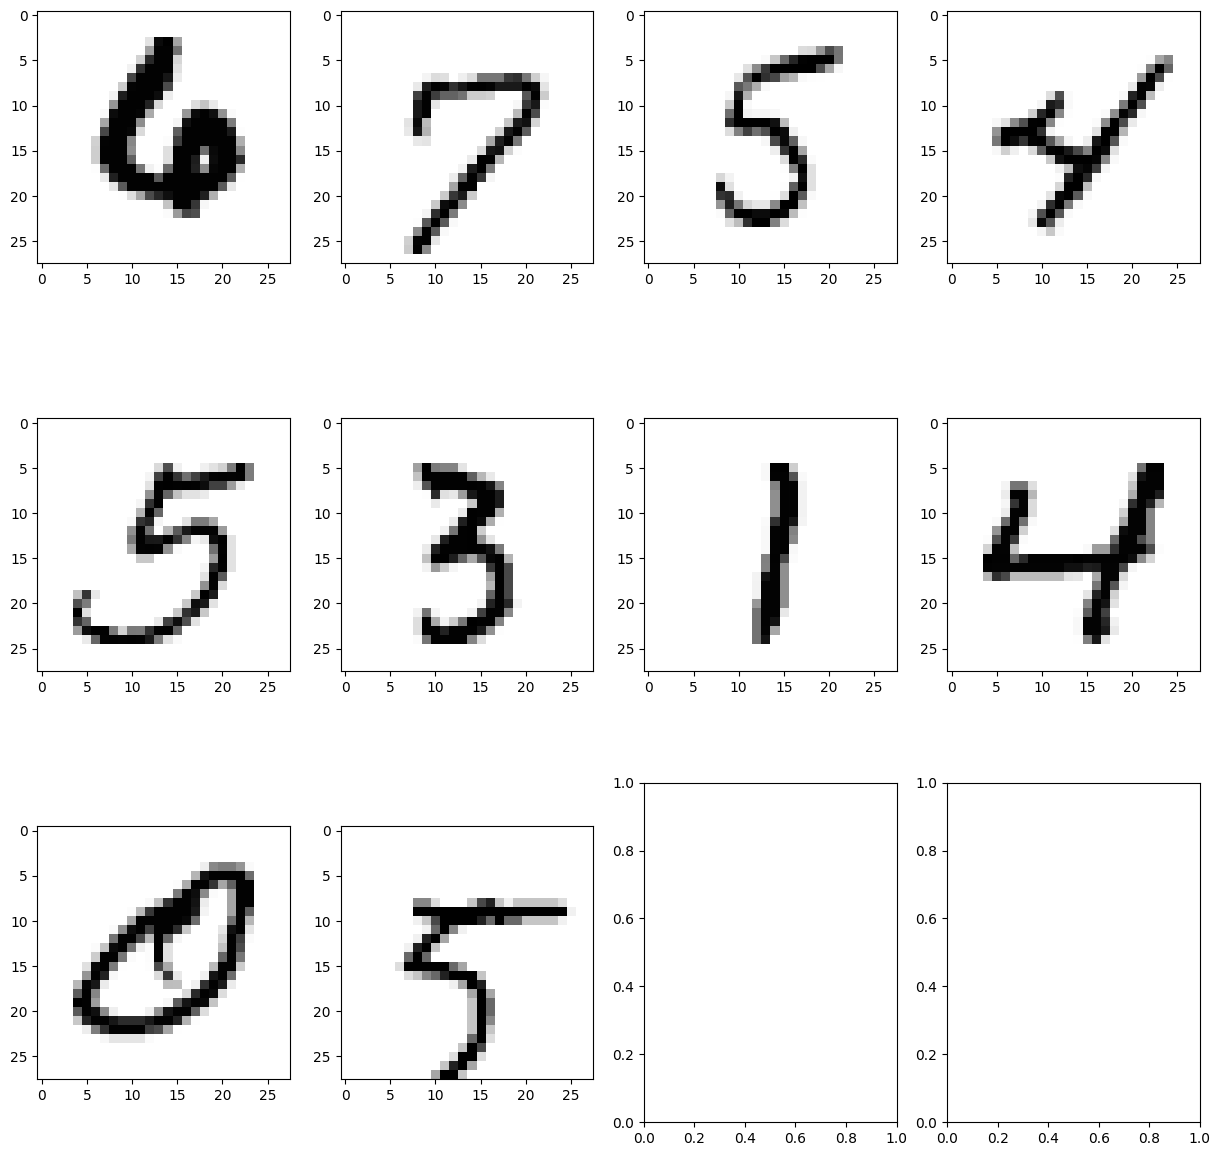

In [66]:
plot_imgs(10, train_ds)